In [1]:
import pandas as pd
import numpy as np
from scipy import  stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csc_matrix, hstack
from sklearn.model_selection import cross_validate, train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.preprocessing import OneHotEncoder
from collections import defaultdict
from matplotlib_venn import venn2

In [2]:
def optimize_lgb_clf(X, y, seed, cv, metric, greater_is_better, num_boost_round, early_stopping_rounds, show,**my_scorer):
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
    from sklearn.metrics import make_scorer
    
    '''
    оптимизирует гиперпараметры lightgbm с ранней остановкой и возможностью задать кастомную метрику качества
    
    параметры:
        1) X -признаки
        2) y - таргет
        3) seed - генератор случайных чисел
        4) cv - схема валидации
        5) metric - оптимизируемая метрика
        6) greater_is_better - направление улучшения значений метрики
        7) num_boost_round - ранняя остановка
        8) early_stopping_rounds - ранняя остановка
        9) show - показывать процесс оптимизации
        10) кастомная метрика (необязательный аргумент)
    
    возвращает:
        1) оптимальное значение метрики
        2) оптимальные гиперпараметры    
    '''
    
    
        
    ###############################################################################################################    
    def _fit_grid(X, y, seed, cv, metric, greater_is_better, grid, num_boost_round, early_stopping_rounds, show):
        if greater_is_better:   
            best_metric = 0
        else:
            best_metric = np.inf            
        for parameters in tqdm_notebook(ParameterGrid(grid)):
            estimator = LGBMClassifier(random_state = seed, **params)
            metrics = []
            try:
                for tr_idx, val_idx in cv.split(X):
                    data_tr = lgb.Dataset(X[tr_idx], label=y[tr_idx])
                    data_val = lgb.Dataset(X[val_idx], label=y[val_idx])
                    estimator.train(parameters,
                                    data_tr,
                                    valid_sets=data_val,
                                    num_boost_round=num_boost_round,
                                    early_stopping_rounds=early_stopping_rounds)
                    if metric =='roc_auc':
                        metrics.append(roc_auc_score(y[val_idx], estimator.predict_proba(data_val)[:, 1]))
                    if metric == 'f1':
                        metrics.append(f1_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'accuracy':
                        metrics.append(accuracy_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'precision':
                        metrics.append(precision_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'recall':
                        metrics.append(recall_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'custom':
                        metrics.append(**my_scorer(y[val_idx], estimator.predict(data_val)))
                    if metric == 'custom_prob':
                        metrics.append(**my_scorer(y[val_idx], estimator.predict_proba(data_val)[:, 1]))
                        
                mean_metric = np.mean(metrics)
                if greater_is_better:                    
                    if mean_metric>best_metric:
                        best_metric = mean_metric
                        if show:
                            print('best score = {}'.format(best_metric))
                        best_params = parameters
                else:
                    if mean_metric<best_metric:
                        best_metric = mean_metric
                        if show:
                            print('best score = {}'.format(best_metric))
                        best_params = parameters
                    
            except:
                for tr_idx, val_idx in cv.split(X, y):
                    data_tr = lgb.Dataset(X[tr_idx], label=y[tr_idx])
                    data_val = lgb.Dataset(X[val_idx], label=y[val_idx])
                    estimator.train(parameters,
                                    data_tr,
                                    valid_sets=data_val,
                                    num_boost_round=num_boost_round,
                                    early_stopping_rounds=early_stopping_rounds)
                    if metric =='roc_auc':
                        metrics.append(roc_auc_score(y[val_idx], estimator.predict_proba(data_val)[:, 1]))
                    if metric == 'f1':
                        metrics.append(f1_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'accuracy':
                        metrics.append(accuracy_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'precision':
                        metrics.append(precision_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'recall':
                        metrics.append(recall_score(y[val_idx], estimator.predict(data_val)))
                    if metric == 'custom':
                        metrics.append(**my_scorer(y[val_idx], estimator.predict(data_val)))
                    if metric == 'custom_prob':
                        metrics.append(**my_scorer(y[val_idx], estimator.predict_proba(data_val)[:, 1]))
                        
                mean_metric = np.mean(metrics)
                if greater_is_better:                    
                    if mean_metric>best_metric:
                        best_metric = mean_metric
                        if show:
                            print('best score = {}'.format(best_metric))
                        best_params = parameters
                else:
                    if mean_metric<best_metric:
                        best_metric = mean_metric
                        if show:
                            print('best score = {}'.format(best_metric))
                        best_params = parameters
                        
        return (best_metric, best_params)
    ##########################################################################################################################
    max_depths = np.arange(3, 11).tolist()
    num_leaves = [2**i for i in range(1, 10)]
    min_child_samples = [20, 50, 100, 500, 1000]
    
    grid1 = {'max_depth' : max_depths,\
            'num_leaves' : num_leaves,\
            'min_child_samples' : min_child_samples,\
            'n_estimators' : [500], 'learning_rate' :[.05]}
    
    best_metric, best_params = _fit_grid(X = X, y = y, seed = seed, cv = cv, metric = metric,\
                                         greater_is_better = greater_is_better,\
                                         grid = grid1, num_boost_round = num_boost_round,\
                                         early_stopping_rounds = early_stopping_rounds, show = show) 
    
    grid2 = {'max_depth' : [best_params['max_depth']-1, best_params['max_depth'], best_params['max_depth']+1],\
            'num_leaves' : [best_params['num_leaves']-8, best_params['num_leaves'], best_params['num_leaves']+8],\
            'min_child_samples' : [best_params['min_child_samples']-10, best_params['min_child_samples'],\
                                   best_params['min_child_samples']+10],\
            'n_estimators' : [500], 'learning_rate' :np.linspace(.01, .06, 10),\
            'subsample' : [.5, .7, 1], 'colsample_bytree' : [.5, .7, 1]}
    best_metric2, best_params2 = _fit_grid(X = X, y = y, seed = seed, cv = cv, metric = metric,\
                                         greater_is_better = greater_is_better,\
                                         grid = grid2, num_boost_round = num_boost_round,\
                                         early_stopping_rounds = early_stopping_rounds, show = show) 
    
    return (best_metric2, best_params2)
    


class FeatureSelector():
    
    '''
    класс, реализующий отбор признаков
    
    гиперпараметры:
        1) estimator - модель, с помощью которой осуществляется отбор признаков
        2) cv - схема валидации
        3) metric - оптимизируемая метрика
        4) use_recursion - использовать рекурсию
        5) fill_value - значение, которым заполняются np.nan
        6) use_value - использовать отбор значений признаков
        7) show_progress - печатать прогресс
    '''
    
    def __init__(self, estimator, cv, metric, use_recursion, fill_value, use_value, show_progress):
        self.estimator = estimator
        self.cv = cv
        self.use_recursion = use_recursion
        self.metric = metric
        self.fill_value = fill_value
        self.use_value = use_value
        self.show_progress = show_progress
        
    def fit(self, X, y):
        '''
        1) считается валидация каждого признака+значений признаков
        2) жадным способом добавляются признаки/значения 
        3) если используется рекурсия, добавляется рекурсивный отбор
            
        '''
        
        try:
            X[np.isnan(X)] = self.fill_value
        except:
            pass
        
        scores = []
        for col_idx in tqdm_notebook(range(X.shape[1])):
            series = X[:, col_idx]
            if self.use_value is None:
                scores.append((col_idx, None,\
                               cross_validate(self.estimator, series.reshape(-1,1), y,\
                                              scoring =self.metric, cv = self.cv)['test_score'].mean()))
            else:                                
                if col_idx in self.use_value:
                    unique_values = np.unique(series[~np.isnan(series)])
                    for val in tqdm_notebook(unique_values):
                        _x = (series == val).astype(int).reshape(-1,1)
                        scores.append((col_idx, val, cross_validate(self.estimator, _x,\
                                              y, scoring =self.metric, cv = self.cv)['test_score'].mean()))
                else:
                    scores.append((col_idx, None,\
                                   cross_validate(self.estimator, series.reshape(-1,1), y,\
                                                  scoring =self.metric, cv = self.cv)['test_score'].mean()))
                
        order = []
        for row in sorted(scores, key=lambda x: x[-1], reverse = True):
            order.append((row[0], row[1]))
                
        D_selected = defaultdict(list)
        best_score = .5
        best_features = []
        to_drop = []
        
        for element in tqdm_notebook(order):            
            column, value = element[0], element[1]

            if value is not None:
                D_selected[column].append(value)
                L = []
                for feat, values in D_selected.items():
                    L.append(list(map(lambda x: x if x in values else -1, X[:, feat])))
                xcurr1 = np.column_stack(L)
            else:
                current_features = best_features + [column]
                xcurr2 = X[:, current_features]
            try:
                xcurr = csc_matrix(hstack([xcurr1, xcurr2]))
            except:
                try:
                    xcurr = xcurr1
                except:
                    xcurr = xcurr2
                    
            current_score = cross_validate(self.estimator, xcurr, y,\
                                           scoring =self.metric, cv = self.cv)['test_score'].mean()
            if current_score>best_score:
                best_score = current_score
                if self.show_progress:
                    print('new best score = {}'.format(best_score))
                if value is not None:
                    pass
                else:
                    best_features = current_features
            else:
                if value is not None:
                    D_selected[column] = [val for val in D_selected[column] if val != value]
                    to_drop.append((column, value))
                else:
                    to_drop.append((column, value)) 
                    
        if self.use_recursion:
            to_drop_before = to_drop
            to_drop_after = []
            while True:
                for element in tqdm_notebook(to_drop_before):            
                    column, value = element[0], element[1]
                    if value is not None:
                        D_selected[column].append(value)
                        L = []
                        for feat, values in D_selected.items():
                            L.append(list(map(lambda x: x if x in values else -1, X[:, feat])))
                        xcurr1 = np.column_stack(L)
                    else:
                        current_features = best_features + [column]
                        xcurr2 = X[:, current_features]
                    try:
                        xcurr = csc_matrix(hstack([xcurr1, xcurr2]))
                    except:
                        try:
                            xcurr = xcurr1
                        except:
                            xcurr = xcurr2

                    current_score = cross_validate(self.estimator, xcurr, y,\
                                                   scoring =self.metric, cv = self.cv)['test_score'].mean()
                    if current_score>best_score:
                        best_score = current_score
                        if self.show_progress:
                            print('new best score = {}'.format(best_score))
                        if value is not None:
                            pass
                        else:
                            best_features = current_features
                    else:
                        if value is not None:
                            D_selected[column] = [val for val in D_selected[column] if val != value]
                            to_drop_after.append((column, value))
                        else:
                            to_drop_after.append((column, value)) 
                            
                if len(to_drop_after) == len(to_drop_before):
                    break
                else:
                    to_drop_before= to_drop_after
                    to_drop_after = []
        
        self.D_selected = D_selected
        self.best_features = best_features
        self.best_score = best_score
        return self
        
    def transform(self, X):
        '''
        в матрице X оставляются отобранные признаки+значения признаков
        '''
        try:
            X[np.isnan(X)] = self.fill_value
        except:
            pass
        if len(self.best_features) !=0:
            x1 = X[:, self.best_features]
        else:
            x1 = None
        if len(list(self.D_selected.keys())) !=0:
            L=[]
            for k, v in self.D_selected.items():
                L.append(list(map(lambda x: x if x in v else self.fill_value, X[:, k])))
            x2 = np.column_stack(L)
        else:
            x2 = None
            
        if (x1 is not None) & (x2 is not None):
            _X = csc_matrix(hstack([f1, f2]))
        if (x1 is not None) & (x2 is None):
            _X = x1
        if (x1 is None) & (x2 is not None):
            _X = x2
        return _X  
    
    def best_score(self):
        return self.best_score

In [3]:
times = ['time%d' % i for i in range(1, 11)]
sites = ['site%d' % i for i in range(1, 11)]
SEED = 13

df_tr = pd.read_csv('train_sessions.csv', parse_dates = times).set_index('session_id').sort_values('time1')
df_te = pd.read_csv('test_sessions.csv', parse_dates = times).set_index('session_id')
y_tr = df_tr['target']

дата = 201301, появлений Элис = 0
дата = 201302, появлений Элис = 61
дата = 201303, появлений Элис = 0
дата = 201304, появлений Элис = 38
дата = 201305, появлений Элис = 0
дата = 201306, появлений Элис = 0
дата = 201307, появлений Элис = 0
дата = 201308, появлений Элис = 0
дата = 201309, появлений Элис = 377
дата = 201310, появлений Элис = 0
дата = 201311, появлений Элис = 446
дата = 201312, появлений Элис = 134
дата = 201401, появлений Элис = 129
дата = 201402, появлений Элис = 410
дата = 201403, появлений Элис = 400
дата = 201404, появлений Элис = 302


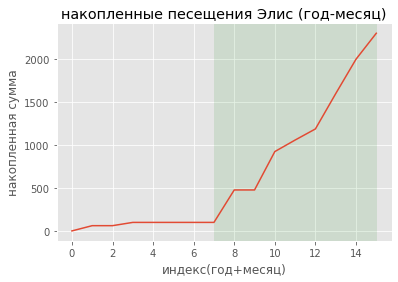

In [4]:
df_tr['ym'] = df_tr['time1'].dt.year*100+df_tr['time1'].dt.month
target_by_ym = df_tr.groupby('ym')['target'].sum()
for _ym, _total_alice in target_by_ym.items():
    print('дата = {}, появлений Элис = {}'.format(_ym, _total_alice))
    

target_by_ym.cumsum().reset_index(drop = True).plot()
plt.title('накопленные песещения Элис (год-месяц)')
plt.xlabel('индекс(год+месяц)')
plt.ylabel('накопленная сумма')
plt.axvspan(7, 15, color = 'green', alpha = .1)
plt.show()    


### актуальный период начинается после 201309, когда активность Элис возобновляется

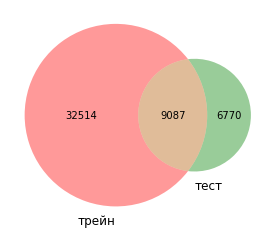

In [5]:
sites_unique_tr = pd.Series(df_tr[sites].values.flatten()).dropna().unique()
sites_unique_te = pd.Series(df_te[sites].values.flatten()).dropna().unique()

set_sites_tr = set(sites_unique_tr)
set_sites_te = set(sites_unique_te)

venn2([set_sites_tr, set_sites_te], ('трейн', 'тест'))

plt.show()

### оставим в трейне сайты, которые посещались Элис+присутствуют в тест части, чтобы не переобучаться на трейн

In [6]:
# оставляем в трейне сайты, которые были посещены Элис + присутствуют в тест части
sites_to_use = np.intersect1d(pd.Series(df_tr[sites][y_tr==1].values.flatten()).dropna().unique(),\
                              pd.Series(df_te[sites].values.flatten()).dropna().unique())
sites_tr = df_tr[sites].applymap(lambda x: x if x in sites_to_use else -1)

### дата: день года, неделя года, год, месяц, день, день недели, час(оставим данные из тест части)

In [7]:
D_ts = {}
for name, _df in zip(('train', 'test'), (df_tr, df_te)):
    start = _df[times].min(1).dt.round('H')
    
    D_ts[name] = pd.concat([start.dt.dayofyear,
                            start.dt.weekofyear,
                            start.dt.quarter,
                            start.dt.year,
                            start.dt.month,
                            start.dt.day,
                            start.dt.dayofweek,
                            start.dt.hour], 1)
    
for col in D_ts['test'].columns:
    values_to_use = D_ts['test'][col].dropna().unique()
    D_ts['train'][col] = D_ts['train'][col].apply(lambda x:x if x in values_to_use else -1)

In [8]:
# модели
logit_clf = LogisticRegression(random_state = SEED)
lgb_clf = LGBMClassifier(random_state = SEED)

# доля отложенной части
HOLDOUT_SHARE = .1
idx_split = np.int32(np.around(len(y_tr)*(1-HOLDOUT_SHARE)))

In [9]:
# время
_X_ts_tr = D_ts['train'].values
# ohe
encoder = OneHotEncoder(handle_unknown='ignore')
_X_ts_ohe_tr = encoder.fit_transform(_X_ts_tr)
# сайты
_X_sites_tr = sites_tr
# таргет
_y_tr = np.array(y_tr)

In [ ]:
print('{} | {} | {} | {:<6} | {:<6} | {:<6} | {:<6}'.format('nfolds', 'ngram_range',\
                                                            'max_features', 'lgb cv', 'logit cv', 'lgb ho', 'logit ho'))
print('---------------------------------------------------------------------------')

maxfeatures_range = (1e2, 1e3, 1e4, 1e5, 5e5)
ngram_range_range = ((1, 1), (1, 2), (1, 3), (1, 4), (1, 5))
cv_sites = []
for nfolds in [3, 5, 7, 9]:
    TSCV = TimeSeriesSplit(nfolds)
    for _ngram_range in ngram_range_range:    
        for i, _max_features in enumerate(maxfeatures_range):
            vec = TfidfVectorizer(ngram_range = _ngram_range, max_features = np.int32(_max_features))
            tfidf_full = vec.fit_transform(pd.concat([sites_tr, df_te[sites]], 0)\
                                           .astype(str).apply(lambda x: '_'.join(x), axis = 1))
            tfidf_tr = tfidf_full[:len(y_tr)]
            cv_lgb = cross_validate(lgb_clf, tfidf_tr[:idx_split], _y_tr[:idx_split],\
                                            scoring = 'roc_auc', cv = TSCV)['test_score'].mean()
            lgb_clf.fit(tfidf_tr[:idx_split], _y_tr[:idx_split])
            lgb_holdout = roc_auc_score(_y_tr[idx_split:], lgb_clf.predict_proba(tfidf_tr[idx_split:])[:, 1])
            
            cv_logit = cross_validate(logit_clf, tfidf_tr[:idx_split], _y_tr[:idx_split],\
                                            scoring = 'roc_auc', cv = TSCV)['test_score'].mean()
            logit_clf.fit(tfidf_tr[:idx_split], _y_tr[:idx_split])
            logit_holdout = roc_auc_score(_y_tr[idx_split:], logit_clf.predict_proba(tfidf_tr[idx_split:])[:, 1])
            
            cv_sites.append((nfolds, _ngram_range, _max_features,cv_lgb,cv_logit))
            
            
            
            print('{:<6} | {:<11} | {:<12} | {:.4f} | {:.6f} | {:.4f} | {:.4f}'.format(nfolds, str(_ngram_range),\
                                                                     np.int32(_max_features),\
                                                                     cv_lgb, cv_logit,\
                                                                     lgb_holdout, logit_holdout))

nfolds | ngram_range | max_features | lgb cv | logit cv | lgb ho | logit ho
---------------------------------------------------------------------------
3      | (1, 1)      | 100          | 0.8715 | 0.845968 | 0.9197 | 0.9229
3      | (1, 1)      | 1000         | 0.8917 | 0.873580 | 0.9265 | 0.9226
3      | (1, 1)      | 10000        | 0.8974 | 0.895382 | 0.9294 | 0.9292
3      | (1, 1)      | 100000       | 0.9021 | 0.898661 | 0.9260 | 0.9291
3      | (1, 1)      | 500000       | 0.9021 | 0.898661 | 0.9260 | 0.9291
3      | (1, 2)      | 100          | 0.8851 | 0.863838 | 0.9164 | 0.9143
3      | (1, 2)      | 1000         | 0.8964 | 0.870675 | 0.9245 | 0.9222
3      | (1, 2)      | 10000        | 0.8953 | 0.893099 | 0.9279 | 0.9288
3      | (1, 2)      | 100000       | 0.9011 | 0.899790 | 0.9271 | 0.9329
3      | (1, 2)      | 500000       | 0.9042 | 0.902313 | 0.9302 | 0.9344
3      | (1, 3)      | 100          | 0.8809 | 0.863408 | 0.9252 | 0.9190
3      | (1, 3)      | 1000       

### отберем признаки для разного числа фолдов (3-10) и разных моделей (logit, lgb). каждые признаки засабмитим и проверим лидерборд
* TfidfVectorizer(ngram_range = (1, 2), max_features = 500000)

In [ ]:
# tfidf
vec = TfidfVectorizer(ngram_range = (1, 2), max_features = 500000)
nfolds_range = np.arange(3, 11)

In [ ]:

for nfolds in tqdm_notebook(nfolds_range):
    
    # валидация
    TSCV = TimeSeriesSplit(nfolds)    
    
    # трансформируем сайты
    tfidf_full = vec.fit_transform(pd.concat([sites_tr, df_te[sites]], 0)\
                                           .astype(str).apply(lambda x: '_'.join(x), axis = 1))
    tfidf_tr = tfidf_full[:len(y_tr)]
    
    # признаки
    _logit_X_tr = csc_matrix(hstack([_X_ts_ohe_tr, tfidf_tr]))
    _lgb_X_tr = csc_matrix(hstack([_X_ts_tr, tfidf_tr]))
    
    # отбираем признаки logit
    logit_selector = FeatureSelector(estimator = logit_clf, cv = TSCV,\
                                     metric = 'roc_auc', use_recursion = True,\
                                     fill_value = -1, use_value = None,\
                                     show_progress = True)
    logit_selector.fit(_logit_X_tr[:idx_split], _y_tr[:idx_split])
    X_selected_logit = logit_selector.transform(_logit_X_tr)
    with open(f'logit_selector_{nfolds}.pickle', 'wb') as f:
        pickle.dump(X_selected_logit, f)
        
    # отбираем признаки lgb
    lgb_selector = FeatureSelector(estimator = lgb_clf, cv = TSCV,\
                                     metric = 'roc_auc', use_recursion = True,\
                                     fill_value = -1, use_value = np.arange(_X_ts_tr.shape[1]).tolist(),\
                                     show_progress = True)
    lgb_selector.fit(_lgb_X_tr[:idx_split], _y_tr[:idx_split])
    X_selected_lgb = lgb_selector.transform(_lgb_X_tr)
    with open(f'lgb_selector_{nfolds}.pickle', 'wb') as f:
        pickle.dump(X_selected_lgb, f)

In [ ]:
# валидация
TSCV = TimeSeriesSplit(3)    
    
# трансформируем сайты
tfidf_full = vec.fit_transform(pd.concat([sites_tr, df_te[sites]], 0)\
                                 .astype(str).apply(lambda x: '_'.join(x), axis = 1))
tfidf_tr = tfidf_full[:len(y_tr)]
    
# признаки
_logit_X_tr = csc_matrix(hstack([_X_ts_ohe_tr, tfidf_tr]))
_lgb_X_tr = csc_matrix(hstack([_X_ts_tr, tfidf_tr]))
    
# отбираем признаки logit
logit_selector = FeatureSelector(estimator = logit_clf, cv = TSCV,\
                                 metric = 'roc_auc', use_recursion = True,\
                                 fill_value = -1, use_value = None,\
                                 show_progress = True)
logit_selector.fit(_logit_X_tr[:idx_split], _y_tr[:idx_split])
X_selected_logit = logit_selector.transform(_logit_X_tr)
with open('logit_selector_3.pickle', 'wb') as f:
    pickle.dump(X_selected_logit, f)
        
# отбираем признаки lgb
lgb_selector = FeatureSelector(estimator = lgb_clf, cv = TSCV,\
                               metric = 'roc_auc', use_recursion = True,\
                               fill_value = -1, use_value = np.arange(_X_ts_tr.shape[1]).tolist(),\
                               show_progress = True)
lgb_selector.fit(_lgb_X_tr[:idx_split], _y_tr[:idx_split])
X_selected_lgb = lgb_selector.transform(_lgb_X_tr)
with open('lgb_selector_3.pickle', 'wb') as f:
    pickle.dump(X_selected_lgb, f)

In [ ]:
# best_metric, best_params = optimize_lgb_clf(X_selected_logit, y_tr, seed=SEED, TimeSeriesSplit(3),\
#                                             metric = 'roc_auc', greater_is_better=True,\
#                                             num_boost_round=5000, early_stopping_rounds=100, show = True)

In [11]:
for nfolds in range(3, 11):
    TSCV = TimeSeriesSplit(nfolds)
    logit_cv1 = cross_validate(logit_clf, _X_ts_ohe_tr[:idx_split], _y_tr[:idx_split],\
                               scoring ='roc_auc', cv = TSCV, return_estimator = True) 
    logit_cv2 = cross_validate(logit_clf, _X_sites_tr[:idx_split], _y_tr[:idx_split],\
                               scoring ='roc_auc', cv = TSCV, return_estimator = True)
    lgb_cv1 = cross_validate(lgb_clf, _X_ts_tr[:idx_split], _y_tr[:idx_split],\
                             scoring ='roc_auc', cv = TSCV, return_estimator = True)
    lgb_cv2 = cross_validate(lgb_clf, _X_sites_tr[:idx_split], _y_tr[:idx_split],\
                             scoring ='roc_auc', cv = TSCV, return_estimator = True)

    print('auc(ohe время+logit) = {}'.format(logit_cv1['test_score'].mean()))
    print('auc(сайты+logit) = {}'.format(logit_cv2['test_score'].mean()))
    print('auc(время+lgb) = {}'.format(lgb_cv1['test_score'].mean()))
    print('auc(сайты+lgb) = {}'.format(lgb_cv2['test_score'].mean()))

    _X_tr = np.column_stack([_X_ts_tr, _X_sites_tr])

    # отбираем признаки даты для бустинга
    lgb_selector = FeatureSelector(estimator = lgb_clf, cv = TSCV,\
                                   metric = 'roc_auc', use_recursion = True,\
                                   fill_value = -1, use_value = np.arange(_X_ts_tr.shape[1]).tolist(),\
                                   show_progress = True)
    lgb_selector.fit(_X_tr[:idx_split], _y_tr[:idx_split])
    print('--------------------------------------------------------------------------------------------')

auc(ohe время+logit) = 0.7810258812336244
auc(сайты+logit) = 0.8899046564476084
auc(время+lgb) = 0.867195056363296
auc(сайты+lgb) = 0.8918548648204275


new best score = 0.7709360662801656
new best score = 0.8311386163705166
new best score = 0.8572793468603981
new best score = 0.8628700751593019
new best score = 0.8711996876394895
new best score = 0.8797622898364658
new best score = 0.8820876344872131
new best score = 0.8845040204795622
new best score = 0.8908939550911241
new best score = 0.8930154585314822



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




Traceback (most recent call last):
  File "C:\Users\Sergey\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-01efd8f011c6>", line 6, in <module>
    lgb_selector.fit(_X_tr[:idx_split], _y_tr[:idx_split])
  File "<ipython-input-2-6988ce90faf1>", line 268, in fit
    current_score = cross_validate(self.estimator, xcurr, y,\
  File "C:\Users\Sergey\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 73, in inner_f
    return f(**kwargs)
  File "C:\Users\Sergey\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 242, in cross_validate
    scores = parallel(


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



  File "C:\Users\Sergey\anaconda3\lib\site-packages\joblib\parallel.py", line 1032, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\Sergey\anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Sergey\anaconda3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "C:\Users\Sergey\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "C:\Users\Sergey\anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "C:\Users\Sergey\anaconda3\lib\site-packages\joblib\parallel.py", line 252, in __call__
    return [func(*args, **kwargs)
  File "C:\Users\Sergey\anaconda3\lib\site-packages\joblib\parallel.py", line 252, in <listcomp>
    return [func(*args, **kwargs)
  File "C:\Users\Sergey\anaconda3\lib\sit

TypeError: object of type 'NoneType' has no len()

In [77]:


L_imp_lgb_time = [est.feature_importances_.flatten() for est in lgb_cv1['estimator']]
imps_lgb_time_mean = sum(L_imp_lgb_time) / len(L_imp_lgb_time)
L_imp_lgb_site = [est.feature_importances_.flatten() for est in lgb_cv2['estimator']]
imps_lgb_site_mean = sum(L_imp_lgb_site) / len(L_imp_lgb_site)

auc(ohe время+logit) = 0.7810258812336244
auc(сайты+logit) = 0.8899046564476084
auc(время+lgb) = 0.867195056363296
auc(сайты+lgb) = 0.8918548648204275


In [78]:
mask = df_tr['ym']>=201309
# время
_X_ts_tr2 = D_ts['train'][mask].values
# ohe
encoder = OneHotEncoder(handle_unknown='ignore')
_X_ts_ohe_tr2 = encoder.fit_transform(_X_ts_tr2)
# сайты
_X_sites_tr2 = sites_tr[mask]
# таргет
_y_tr2 = np.array(y_tr[mask])
# трейн-тест сплит
idx_split2 = np.int32(np.around(len(_y_tr2)*(1-HOLDOUT_SHARE)))

In [79]:
logit_cv1_mask = cross_validate(logit_clf, _X_ts_ohe_tr2[:idx_split2], _y_tr2[:idx_split2],\
                           scoring ='roc_auc', cv = TSCV, return_estimator = True) 
logit_cv2_mask = cross_validate(logit_clf, _X_sites_tr2[:idx_split2], _y_tr2[:idx_split2],\
                           scoring ='roc_auc', cv = TSCV, return_estimator = True)
lgb_cv1_mask = cross_validate(lgb_clf, _X_ts_tr2[:idx_split2], _y_tr2[:idx_split2],\
                         scoring ='roc_auc', cv = TSCV, return_estimator = True)
lgb_cv2_mask = cross_validate(lgb_clf, _X_sites_tr2[:idx_split2], _y_tr2[:idx_split2],\
                         scoring ='roc_auc', cv = TSCV, return_estimator = True)

print('auc(ohe время+logit) | ym>=201309 = {}'.format(logit_cv1_mask['test_score'].mean()))
print('auc(сайты+logit) | ym>=201309= {}'.format(logit_cv2_mask['test_score'].mean()))
print('auc(время+lgb) | ym>=201309= {}'.format(lgb_cv1_mask['test_score'].mean()))
print('auc(сайты+lgb) | ym>=201309= {}'.format(lgb_cv2_mask['test_score'].mean()))

L_imp_lgb_time_mask = [est.feature_importances_.flatten() for est in lgb_cv1_mask['estimator']]
imps_lgb_time_mean_mask = sum(L_imp_lgb_time_mask) / len(L_imp_lgb_time_mask)
L_imp_lgb_site_mask = [est.feature_importances_.flatten() for est in lgb_cv2_mask['estimator']]
imps_lgb_site_mean_mask = sum(L_imp_lgb_site_mask) / len(L_imp_lgb_site_mask)

auc(ohe время+logit) | ym>=201309 = 0.8092765694966432
auc(сайты+logit) | ym>=201309= 0.88946832692538
auc(время+lgb) | ym>=201309= 0.8656833142645506
auc(сайты+lgb) | ym>=201309= 0.8955239029489017


In [80]:
for diff, rank in zip((imps_lgb_time_mean - imps_lgb_time_mean_mask)\
                        / np.mean([imps_lgb_time_mean, imps_lgb_time_mean_mask], axis = 0),\
                      np.argsort(imps_lgb_time_mean)):
    print('изменение важности признака / средняя важность признака = {:<5.2f} | ранг признака(больше-лучше) = {}'.format(diff, rank))

изменение важности признака / средняя важность признака = nan   | ранг признака(больше-лучше) = 0
изменение важности признака / средняя важность признака = 2.00  | ранг признака(больше-лучше) = 1
изменение важности признака / средняя важность признака = 0.24  | ранг признака(больше-лучше) = 3
изменение важности признака / средняя важность признака = 0.66  | ранг признака(больше-лучше) = 4
изменение важности признака / средняя важность признака = 0.55  | ранг признака(больше-лучше) = 2
изменение важности признака / средняя важность признака = -0.17 | ранг признака(больше-лучше) = 6
изменение важности признака / средняя важность признака = 0.04  | ранг признака(больше-лучше) = 5
изменение важности признака / средняя важность признака = -0.03 | ранг признака(больше-лучше) = 7


### наиболее важные признаки после удаления части данных несильно повлияли на модель (однако изменение важности на .21 - не очень хорошо)

In [81]:
# отбираем признаки даты для бустинга
lgb_selector = FeatureSelector(estimator = lgb_clf, cv = TSCV,\
                               metric = 'roc_auc', use_recursion = True,\
                               fill_value = -1, use_value = np.arange(_X_ts_tr.shape[1]).tolist(),\
                               show_progress = True)
lgb_selector.fit(_X_ts_tr[:idx_split], _y_tr[:idx_split])

new best score = 0.632848627669736
new best score = 0.7133791977913879
new best score = 0.7814928998427
new best score = 0.8091293571082608
new best score = 0.8588551227309785
new best score = 0.8656242920624592
new best score = 0.883201715019818
new best score = 0.8902765454747409
new best score = 0.8907145945164536
new best score = 0.8953832590444091
new best score = 0.8963070835778517
new best score = 0.9008254084226875
new best score = 0.9052156510561666
new best score = 0.9074311307038898
new best score = 0.9091354074466503
new best score = 0.9158075266690111
new best score = 0.9160719238754749
new best score = 0.9173616286318784
new best score = 0.9178897975032647
new best score = 0.91832812690208
new best score = 0.9185151922152439
new best score = 0.9185200724477548
new best score = 0.9186339218622941
new best score = 0.9186347734260919
new best score = 0.9196808891675021



new best score = 0.9199006531108384
new best score = 0.921206737783148
new best score = 0.9218850842401746



In [83]:
# отбираем признаки даты для бустинга
lgb_selector2 = FeatureSelector(estimator = lgb_clf, cv = TSCV,\
                               metric = 'roc_auc', use_recursion = True,\
                               fill_value = -1, use_value = np.arange(_X_ts_tr2.shape[1]).tolist(),\
                               show_progress = True)
lgb_selector2.fit(_X_ts_tr2[:idx_split2], _y_tr2[:idx_split2])

new best score = 0.6495556626794319
new best score = 0.7234178188153977
new best score = 0.804046617602676
new best score = 0.8266341345535712
new best score = 0.850819597302845
new best score = 0.8710102387579791
new best score = 0.8923404757959993
new best score = 0.8994746970564453
new best score = 0.8998291869928914
new best score = 0.9048607164317243
new best score = 0.9091349748147952
new best score = 0.9135098204344747
new best score = 0.9165368430206406
new best score = 0.9192253732878148
new best score = 0.9226354424566078
new best score = 0.9263554034214188
new best score = 0.9269151634658591
new best score = 0.9271385443762267
new best score = 0.9271385443762268
new best score = 0.9271520337993555
new best score = 0.9271538063042595



new best score = 0.9293094243906406
new best score = 0.940525691752697
new best score = 0.9405576139863272
new best score = 0.9464860074804373



new best score = 0.9471478506201694
new best score = 0.9486056372682902
new best score = 0.9493774267187969



### учитываем посещения после определенного год-месяц

In [100]:
best_score = .5
for ym in np.unique(df_tr['ym']):
    _X_sites_masked_tr = _X_sites_tr.where(df_tr['ym']>=ym).fillna(-1)
    mean_score = cross_validate(logit_clf, _X_sites_masked_tr[:idx_split], _y_tr[:idx_split],\
                           scoring ='roc_auc', cv = TSCV)['test_score'].mean()
    print('ym >= {}, auc = {}'.format(ym, mean_score))
    if mean_score > best_score:
        best_score = mean_score
        best_X = _X_sites_masked_tr

ym >= 201301, auc = 0.8899046564476084
ym >= 201302, auc = 0.889916913389829
ym >= 201303, auc = 0.8911459198179351
ym >= 201304, auc = 0.8924397212707206
ym >= 201305, auc = 0.8929499419196262
ym >= 201306, auc = 0.8934009162667058
ym >= 201307, auc = 0.893709184491182
ym >= 201308, auc = 0.8937104561846932
ym >= 201309, auc = 0.8937147814809048
ym >= 201310, auc = 0.8927424872332437
ym >= 201311, auc = 0.893334476075442
ym >= 201312, auc = 0.7505364240890915
ym >= 201401, auc = 0.7814620409339782
ym >= 201402, auc = 0.5973447485016066
ym >= 201403, auc = 0.3807731017453394
ym >= 201404, auc = 0.49843696033616774


In [101]:
best_score2 = .5
for ym in np.unique(df_tr[mask]['ym']):
    _X_sites_masked_tr2 = _X_sites_tr2.where(df_tr[mask]['ym']>=ym).fillna(-1)
    mean_score = cross_validate(logit_clf, _X_sites_masked_tr2[:idx_split2], _y_tr2[:idx_split2],\
                           scoring ='roc_auc', cv = TSCV)['test_score'].mean()
    print('ym >= {}, auc = {}'.format(ym, mean_score))
    if mean_score > best_score2:
        best_score2 = mean_score
        best_X2 = _X_sites_masked_tr2

ym >= 201309, auc = 0.88946832692538
ym >= 201310, auc = 0.8884917294445058
ym >= 201311, auc = 0.8908272370203263
ym >= 201312, auc = 0.6969036599095216
ym >= 201401, auc = 0.7790502375620708
ym >= 201402, auc = 0.6041044699041078
ym >= 201403, auc = 0.36729181121510435
ym >= 201404, auc = 0.49567390442326115


In [107]:
_X1_tr = np.column_stack([best_X, lgb_selector.transform(_X_ts_tr)])
_X2_tr = np.column_stack([best_X2, lgb_selector.transform(_X_ts_tr2)])

In [111]:
cross_validate(lgb_clf, _X1_tr[:idx_split], _y_tr[:idx_split],\
                           scoring ='roc_auc', cv = TSCV)['test_score'].mean()

0.9391801546307532

In [112]:
cross_validate(lgb_clf, _X2_tr[:idx_split2], _y_tr2[:idx_split2],\
                           scoring ='roc_auc', cv = TSCV)['test_score'].mean()

0.8660627671861059

In [ ]:
# _X_sites_tr2

In [10]:
# отбираем признаки даты для логита
logit_selector = FeatureSelector(estimator = logit_clf, cv = TSCV,\
                                 metric = 'roc_auc', use_recursion = True,\
                                 fill_value = -1, use_value = None,\
                                 show_progress = True)
logit_selector.fit(_X_ts_ohe_tr[:idx_split], _y_tr[:idx_split])

new best score = 0.632848627669736
new best score = 0.7133791977913879
new best score = 0.747802977771624
new best score = 0.7919946144144729
new best score = 0.8165457115328454
new best score = 0.8666677827924736
new best score = 0.8712629274647941
new best score = 0.8863608144268461
new best score = 0.894703203610169
new best score = 0.895095855553345
new best score = 0.8958420338087819
new best score = 0.8968012255515593
new best score = 0.8982926926353396
new best score = 0.9026985264637487
new best score = 0.9030837310896369
new best score = 0.9057457486764413
new best score = 0.9069311928807753
new best score = 0.9076135539903997
new best score = 0.9096688183528874
new best score = 0.9104446362919066
new best score = 0.9107206759399662
new best score = 0.911239514358302
new best score = 0.9120922895108613
new best score = 0.9121894325369281
new best score = 0.9121902431941721
new best score = 0.9127181770205531
new best score = 0.912741600653384
new best score = 0.913636144637689

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Sergey\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-8734b7561ba8>", line 6, in <module>
    logit_selector.fit(_X_ts_ohe_tr[:idx_split], _y_tr[:idx_split])
  File "<ipython-input-2-6988ce90faf1>", line 268, in fit
    current_score = cross_validate(self.estimator, xcurr, y,\
  File "C:\Users\Sergey\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 73, in inner_f
    return f(**kwargs)
  File "C:\Users\Sergey\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 242, in cross_validate
    scores = parallel(
  File "C:\Users\Sergey\anaconda3\lib\site-packages\joblib\parallel.py", line 1032, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\Sergey\anaconda3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:

TypeError: object of type 'NoneType' has no len()

In [55]:
cv_sites = []
maxfeatures_range = (1e2, 1e3, 1e4, 1e5)
ngram_range_range = ((1,2), (1, 3), (1, 4))
for _ngram_range in tqdm_notebook(ngram_range_range):    
    for i, _max_features in tqdm_notebook(enumerate(maxfeatures_range), total = len(maxfeatures_range)):
        vec = TfidfVectorizer(ngram_range = _ngram_range, max_features = _max_features)
        tfidf_full = vec.fit_transform(pd.concat([sites_tr, df_te[sites]], 0).astype(str).apply(lambda x: '_'.join(x), axis = 1))
        tfidf_tr = tfidf12_full[:len(y_tr)]
        cv_sites.append((n, i,\
                         cross_validate(lgb_clf, tfidf_tr[:idx_split], _y_tr[:idx_split],\
                                        scoring = 'roc_auc', cv = TSCV)['test_score'].mean(),\
                         cross_validate(logit_clf, tfidf_tr[:idx_split], _y_tr[:idx_split],\
                                        scoring = 'roc_auc', cv = TSCV)['test_score'].mean()))
        

In [56]:
cv_sites_lgb

[(2, 0, 0.8796130969359011),
 (2, 1, 0.8811247839402754),
 (2, 2, 0.8810636546491293),
 (2, 3, 0.882962592793179),
 (2, 4, 0.8821374061988855),
 (2, 5, 0.8826950098891215),
 (2, 6, 0.8823655392205821),
 (2, 7, 0.8799434663333914),
 (2, 8, 0.8836145563952456),
 (2, 9, 0.8798578129654416),
 (2, 10, 0.8843096480903438),
 (2, 11, 0.884502781913048),
 (2, 12, 0.8847378511070938),
 (2, 13, 0.8838533256382559),
 (2, 14, 0.8858453219058625),
 (2, 15, 0.8871112099282197),
 (2, 16, 0.884947476305779),
 (2, 17, 0.8868134366726654),
 (2, 18, 0.8850305674839518),
 (2, 19, 0.8870584335957661),
 (2, 20, 0.8865154793899018),
 (2, 21, 0.8874689324006886),
 (2, 22, 0.8882551443570053),
 (2, 23, 0.8885612765253499),
 (2, 24, 0.8867739848654413),
 (2, 25, 0.8882176931570595),
 (2, 26, 0.8874434358618509),
 (2, 27, 0.8873067201718827),
 (2, 28, 0.8859888796263669),
 (2, 29, 0.8852145130731448),
 (2, 30, 0.8857926140956811),
 (2, 31, 0.888151494631783),
 (2, 32, 0.8885285331294152),
 (2, 33, 0.8879410757904

In [57]:
cv_sites_logit

[(2, 0, 0.8644684997568386),
 (2, 1, 0.8719409468601789),
 (2, 2, 0.8758416123240949),
 (2, 3, 0.8774855419576613),
 (2, 4, 0.8816723231703574),
 (2, 5, 0.8830319877310491),
 (2, 6, 0.8844154954484622),
 (2, 7, 0.8845006469427894),
 (2, 8, 0.8854871095447379),
 (2, 9, 0.8873127727350469),
 (2, 10, 0.8885389322765498),
 (2, 11, 0.8887110423294686),
 (2, 12, 0.8890220184401996),
 (2, 13, 0.8895190829217463),
 (2, 14, 0.889829164904044),
 (2, 15, 0.8898771271915646),
 (2, 16, 0.8902852495901676),
 (2, 17, 0.890321872644025),
 (2, 18, 0.8906414807785614),
 (2, 19, 0.8906509336714501),
 (2, 20, 0.8907259722366228),
 (2, 21, 0.8908938763073426),
 (2, 22, 0.8908739816797249),
 (2, 23, 0.8911328687835166),
 (2, 24, 0.8912067793023781),
 (2, 25, 0.8911825655395587),
 (2, 26, 0.891292385884623),
 (2, 27, 0.8916520736212383),
 (2, 28, 0.8918321446585471),
 (2, 29, 0.8919698160146405),
 (2, 30, 0.8920908408342256),
 (2, 31, 0.8920578976619453),
 (2, 32, 0.8920982689267987),
 (2, 33, 0.892070341145

In [42]:
# отбираем сайты для бустинга
lgb_selector2 = FeatureSelector(estimator = lgb_clf, cv = TSCV,\
                               metric = 'roc_auc', use_recursion = False,\
                               fill_value = -1, use_value = None,\
                               show_progress = True)
lgb_selector2.fit(tfidf12_tr[:idx_split], _y_tr[:idx_split])

KeyboardInterrupt: 

In [ ]:
# отбираем сайты для логита
logit_selector2 = FeatureSelector(estimator = logit_clf, cv = TSCV,\
                               metric = 'roc_auc', use_recursion = True,\
                               fill_value = -1, use_value = np.arange(_X_sites_tr.shape[1]).tolist(),\
                               show_progress = True)
logit_selector2.fit(_X_sites_tr[:idx_split], _y_tr[:idx_split])